## Environment Setup

The libraries required for the project to run are imported and initialized

In [ ]:
import requests
import pandas
import re
import nltk
import matplotlib.pyplot as plt
import numpy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import regularizers, layers
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop,Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Retrieving the dataset

Since the dataset is hosted on Google Drive, it is fetched and written into a csv file.

In [ ]:
gDrive_share = 'https://drive.google.com/uc?export=download&id=1F3oU61kC2ZqQ9HJLKAmoblehs3ENgUl8'
response = requests.get(gDrive_share, headers = {'Accept': 'application/text'})
with open('twitter_text_data.csv', "w") as twitter_text_data:
  twitter_text_data.write(response.text)

The csv file is now loaded into a pandas dataframe for the next step of data processing and visulization.

In [ ]:
txt_mdl_src = pandas.read_csv("twitter_text_data.csv", sep=',')

## Exploratory Data Analysis (EDA)

Using the dataframe to obtain insights and patterns

In [ ]:
txt_mdl_src

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


The counts for each of the three classes are displayed to look for skewness in the dataset

In [ ]:
print(txt_mdl_src.head())
print(txt_mdl_src['class'].value_counts())


   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
1    19190
2     4163
0     1430
Name: class, dtype: int64


## Data Preprocessing
Using the patterns identified in EDA, the dataset is transformed into a ML model readable format.

The text of the tweet is converted to lowercase and further processed by removing unnecessary charactors, urls, etc.

In [ ]:
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['tweet'].str.lower()
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: src_sentence.replace('rt', ''))
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: re.sub(r'http\S+', '', src_sentence))
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: re.sub(r'[^a-zA-Z\s]', '', src_sentence))

The text is tokenized

In [ ]:
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: word_tokenize(src_sentence))

Stopwords are removed from the tokenized text and each token is stemmed to its root word.

In [ ]:
stop_words = set(stopwords.words('english'))
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: [word for word in src_sentence if word not in stop_words])
stemmer = nltk.SnowballStemmer(language='english')
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: [stemmer.stem(word) for word in src_sentence])

In [ ]:
txt_mdl_src['txt_mdl_src'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence_word: ' '.join(src_sentence_word))

In [ ]:
txt_mdl_src['tweets_deep_learning_txt'] = txt_mdl_src['txt_mdl_src'].apply(lambda src_sentence: src_sentence.split())

## Feature Engineering
The cleaned dataset can now be converted into the appropriate vector matrices for acting as model input.

We are using the Tf-Idf vectorizer for creating input for the bag-of-words models which are SVM, Random Foreat, Multinomial Naive Bayes and Logistic Regression.

In [ ]:
tfidf = TfidfVectorizer()
bog_mdl_txt_data = tfidf.fit_transform(txt_mdl_src['txt_mdl_src'])
bog_mdl_true_cls = txt_mdl_src['class']

For the deep learning model we have used the word embeddings method to generate an input vector

In [ ]:
deep_lrng_tknzr = Tokenizer(num_words=5000)
deep_lrng_tknzr.fit_on_texts(txt_mdl_src['tweets_deep_learning_txt'])
tweet_txt_vector = deep_lrng_tknzr.texts_to_sequences(txt_mdl_src['tweets_deep_learning_txt'])
tweets = pad_sequences(tweet_txt_vector, maxlen=200)
print(tweets)

[[   0    0    0 ...   91   59   15]
 [   0    0    0 ...    2  465  392]
 [   0    0    0 ...  251  764   12]
 ...
 [   0    0    0 ...   14  110  263]
 [   0    0    0 ...    1 1760  203]
 [   0    0    0 ...  106   19   62]]


In [ ]:
len(tweets)

24783

In [ ]:
dp_lrng_labels = numpy.array(txt_mdl_src['class'])
temp = []
for true_label_idx in range(len(dp_lrng_labels)):
    if dp_lrng_labels[true_label_idx] == 2:
        temp.append(2)
    if dp_lrng_labels[true_label_idx] == 1:
        temp.append(1)
    if dp_lrng_labels[true_label_idx] == 0:
        temp.append(0)
temp = numpy.array(temp)
dp_lrng_labels = tf.keras.utils.to_categorical(temp, 3, dtype="float32")
del temp

### Split the dataset into train set and test set
The split is performed in a 80-20 ratio.

In [ ]:
bog_lr_input, bog_lr_pred_input, bog_true_lbl_lr, bog_true_pred_lr = train_test_split(bog_mdl_txt_data, bog_mdl_true_cls, test_size=0.2, random_state=42)
bog_rf_input, bog_rf_pred_input, bog_true_lbl_rf, bog_true_pred_rf = train_test_split(bog_mdl_txt_data, bog_mdl_true_cls, test_size=0.2, random_state=42)
bog_nb_input, bog_nb_pred_input, bog_true_lbl_nb, bog_true_pred_nb = train_test_split(bog_mdl_txt_data, bog_mdl_true_cls, test_size=0.2, random_state=42)
bog_svm_input, bog_svm_pred_input, bog_true_lbl_svm, bog_true_pred_svm = train_test_split(bog_mdl_txt_data, bog_mdl_true_cls, test_size=0.2, random_state=42)

Splitting the word embeddings into training set and test set

In [ ]:
dp_mdl_input, dp_pred_mdl_input, dp_mdl_true, dp_pred_mdl_true = train_test_split(tweets,dp_lrng_labels, random_state=0)

## Model Training and Evaluation

### Bag-of-Words Model Initialization and Training

#### Logistic Regression

In [ ]:
lgstc_rgr_mdl = LogisticRegression(verbose=1, solver='liblinear', random_state=0, C=5)
lgstc_rgr_mdl.fit(bog_lr_input, bog_true_lbl_lr)

[LibLinear]

LogisticRegression(C=5, random_state=0, solver='liblinear', verbose=1)

#### Random Forest

In [ ]:
rndm_frst_mdl = RandomForestClassifier(random_state=0)
rndm_frst_mdl.fit(bog_rf_input, bog_true_lbl_rf)

RandomForestClassifier(random_state=0)

#### Multinomial Naive Bayes

In [ ]:
nv_base_mdl = MultinomialNB(alpha=1.0)
nv_base_mdl.fit(bog_nb_input, bog_true_lbl_nb)

MultinomialNB()

#### Support Vector Machine

In [ ]:
svm_mdl = SVC(kernel='linear', random_state=0)
svm_mdl.fit(bog_svm_input, bog_true_lbl_svm)

SVC(kernel='linear', random_state=0)

### Bag-of-Words Model Evaluation and Visualization

The classifications from the above models are obtained

In [ ]:
lgstc_rgr_mdl_output = lgstc_rgr_mdl.predict(bog_lr_pred_input)
rndm_frst_mdl_output = rndm_frst_mdl.predict(bog_rf_pred_input)
nv_base_mdl_output = nv_base_mdl.predict(bog_nb_pred_input)
svm_mdl_output = svm_mdl.predict(bog_svm_pred_input)

Printing the classification report for each model for better understanding

In [ ]:
print("Logistic Regression Classification Report:\n"+classification_report(bog_true_pred_lr, lgstc_rgr_mdl_output, zero_division=1))
print("Random Forest Classification Report:\n"+classification_report(bog_true_pred_rf, rndm_frst_mdl_output, zero_division=1))
print("Multinomial Naive Bayes Classification Report:\n"+classification_report(bog_true_pred_nb, nv_base_mdl_output, zero_division=1))
print("SVM Classification Report:\n"+classification_report(bog_true_pred_svm, svm_mdl_output, zero_division=1))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28       290
           1       0.91      0.96      0.94      3832
           2       0.83      0.83      0.83       835

    accuracy                           0.89      4957
   macro avg       0.75      0.66      0.68      4957
weighted avg       0.88      0.89      0.88      4957

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.10      0.18       290
           1       0.90      0.97      0.93      3832
           2       0.85      0.78      0.81       835

    accuracy                           0.89      4957
   macro avg       0.78      0.62      0.64      4957
weighted avg       0.87      0.89      0.87      4957

Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       290
  

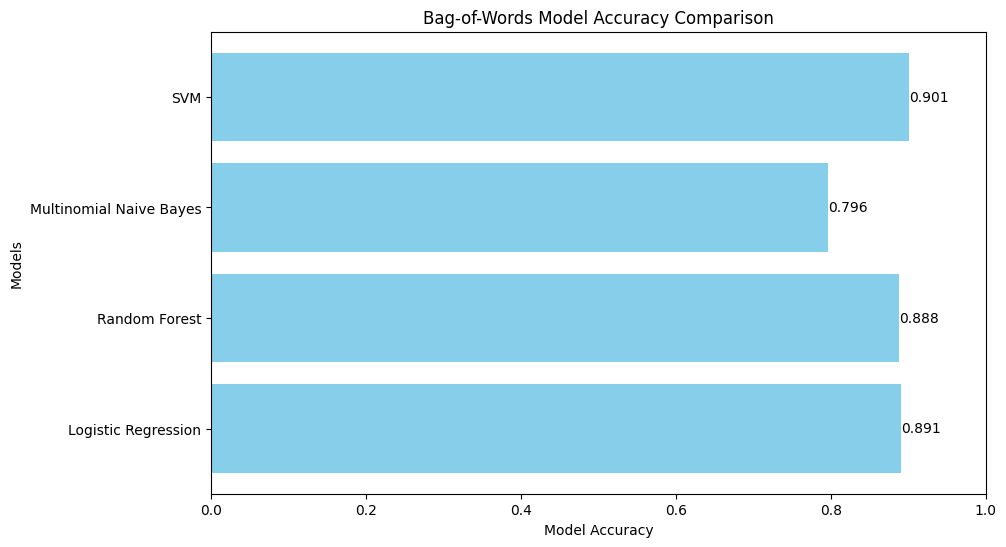

In [ ]:
models = ['Logistic Regression', 'Random Forest', 'Multinomial Naive Bayes', 'SVM']
accuracies = [accuracy_score(bog_true_pred_lr, lgstc_rgr_mdl_output), accuracy_score(bog_true_pred_rf, rndm_frst_mdl_output), accuracy_score(bog_true_pred_nb, nv_base_mdl_output), accuracy_score(bog_true_pred_svm, svm_mdl_output)]
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color='skyblue')
plt.xlabel('Model Accuracy')
plt.ylabel('Models')
plt.title('Bag-of-Words Model Accuracy Comparison')
plt.xlim(0, 1)
for index, value in enumerate(accuracies):
    plt.text(value, index, f"{value:.3f}", ha='left', va='center')
plt.show()


In [ ]:
metric_average_param = 'weighted'
metric_zero_div = 1
bog_mdl_precisions = [precision_score(bog_true_pred_lr, lgstc_rgr_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
             precision_score(bog_true_pred_rf, rndm_frst_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
             precision_score(bog_true_pred_nb, nv_base_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
             precision_score(bog_true_pred_svm, svm_mdl_output, average=metric_average_param, zero_division=metric_zero_div)]
bog_mdl_recalls = [recall_score(bog_true_pred_lr, lgstc_rgr_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
          recall_score(bog_true_pred_rf, rndm_frst_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
          recall_score(bog_true_pred_nb, nv_base_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
          recall_score(bog_true_pred_svm, svm_mdl_output, average=metric_average_param, zero_division=metric_zero_div)]
bog_mdl_f1scores = [f1_score(bog_true_pred_lr, lgstc_rgr_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
      f1_score(bog_true_pred_rf, rndm_frst_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
      f1_score(bog_true_pred_nb, nv_base_mdl_output, average=metric_average_param, zero_division=metric_zero_div),
      f1_score(bog_true_pred_svm, svm_mdl_output, average=metric_average_param, zero_division=metric_zero_div)]
data = {'Model': models, 'Accuracy': accuracies, 'Precision': bog_mdl_precisions, 'Recall': bog_mdl_recalls, 'F1-Score': bog_mdl_f1scores}
bog_mdl_comparisons = pandas.DataFrame(data)
print(bog_mdl_comparisons)


                     Model  Accuracy  Precision    Recall  F1-Score
0      Logistic Regression  0.891063   0.876095  0.891063  0.879204
1            Random Forest  0.888441   0.872273  0.888441  0.869433
2  Multinomial Naive Bayes  0.796248   0.829018  0.796248  0.724941
3                      SVM  0.900746   0.883849  0.900746  0.885021


### Deep Learning Model Initialization

Creating a keras model and training it on the above generated word embeddings

In [ ]:
dp_lrng_mdl = Sequential()
bidrctnl_lyr = layers.Bidirectional(layers.LSTM(20, dropout=0.6))
dense_lyr = layers.Dense(3,activation='softmax')
mdl_param_ls = 'categorical_crossentropy'
mdl_param_opt = 'rmsprop'
mdl_param_metric = ['accuracy']
mdl_param_ckp_metric = 'val_accuracy'
dp_lrng_mdl.add(layers.Embedding(5000, 40, input_length=200))
dp_lrng_mdl.add(bidrctnl_lyr)
dp_lrng_mdl.add(dense_lyr)
dp_lrng_mdl.compile(optimizer=mdl_param_opt,loss=mdl_param_ls, metrics=mdl_param_metric)
mdl_ckpnt = ModelCheckpoint("mdl.hdf5", verbose=1, monitor=mdl_param_ckp_metric, save_best_only=True, period=1)
mdl_metrics = dp_lrng_mdl.fit(dp_mdl_input, dp_mdl_true, epochs=12, validation_data=(dp_pred_mdl_input, dp_pred_mdl_true), callbacks=[mdl_ckpnt])

Epoch 1/12
581/581 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.8346
Epoch 1: val_accuracy improved from -inf to 0.88460, saving model to mdl.hdf5
581/581 [==============================] - 106s 175ms/step - loss: 0.4720 - accuracy: 0.8346 - val_loss: 0.3424 - val_accuracy: 0.8846
Epoch 2/12
581/581 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8895
Epoch 2: val_accuracy improved from 0.88460 to 0.89170, saving model to mdl.hdf5
581/581 [==============================] - 103s 177ms/step - loss: 0.3281 - accuracy: 0.8895 - val_loss: 0.3166 - val_accuracy: 0.8917
Epoch 3/12
581/581 [==============================] - ETA: 0s - loss: 0.2976 - accuracy: 0.8992
Epoch 3: val_accuracy improved from 0.89170 to 0.89606, saving model to mdl.hdf5
581/581 [==============================] - 108s 187ms/step - loss: 0.2976 - accuracy: 0.8992 - val_loss: 0.2885 - val_accuracy: 0.8961
Epoch 4/12
581/581 [==============================] - ETA: 0s - los

### Deep Learning Model Evaluation

In [ ]:
dp_lrng_mdl = load_model("mdl.hdf5")
mdl_loss, mdl_accuracy = dp_lrng_mdl.evaluate(dp_pred_mdl_input, dp_pred_mdl_true)
print(f"Deep Learning LSTM Model - Test Accuracy: {mdl_accuracy:.4f}, Test Loss: {mdl_loss:.4f}")
accuracies.append(mdl_accuracy)

194/194 [==============================] - 7s 29ms/step - loss: 0.2838 - accuracy: 0.9040
Deep Learning LSTM Model - Test Accuracy: 0.9040, Test Loss: 0.2838


### Final Model Evaluation and Visualization

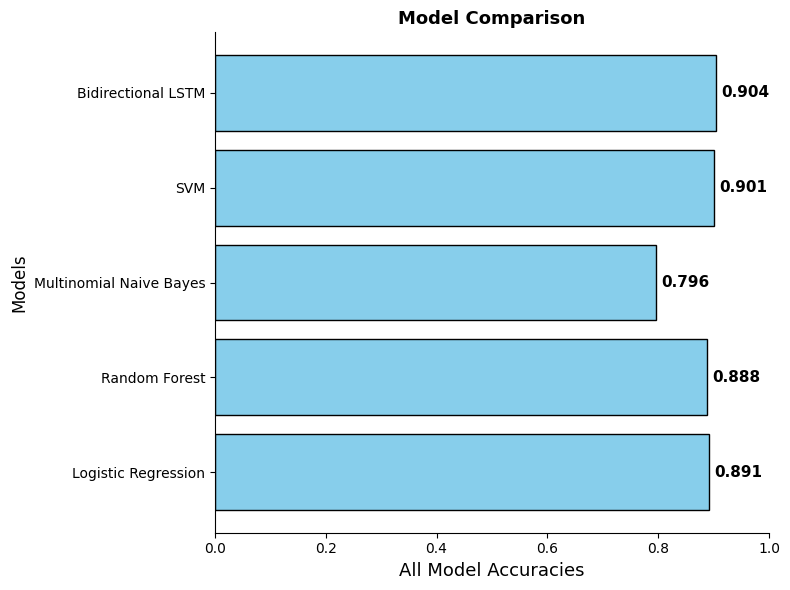

                Model Used  Model Accuracy
0      Logistic Regression        0.891063
1            Random Forest        0.888441
2  Multinomial Naive Bayes        0.796248
3                      SVM        0.900746
4       Bidirectional LSTM        0.903970


In [ ]:
models.append('Bidirectional LSTM')
plt.figure(figsize=(8, 6))
plt.barh(models, accuracies, color='skyblue', edgecolor='black')
plt.xlabel('All Model Accuracies', fontsize=13)
plt.ylabel('Models', fontsize=12)
plt.title('Model Comparison', fontsize=13, fontweight='bold')
plt.xlim(0, 1)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
for i, v in enumerate(accuracies):
    plt.text(v + 0.01, i, f'{v:.3f}', ha='left', va='center', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.show()
data = {'Model Used': models, 'Model Accuracy': accuracies}
df_accuracy = pandas.DataFrame(data)
print(df_accuracy)